In [1]:
!pip install pandas numpy matplotlib seaborn plotly scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
import datetime

In [3]:
def get_user_input():
    user_name = input("Enter your name: ")
    month_year = input("Enter the budget month (MM/YY): ")

    # Validate Date Format
    try:
        datetime.datetime.strptime(month_year, "%m/%y")
    except ValueError:
        print("Invalid format! Please enter in MM/YY format.")
        return get_user_input()
    
    total_money = float(input("Enter your total money: "))
    savings = float(input("Enter your current savings: "))
    min_savings_limit = float(input("Enter the minimum savings limit: "))

    # Savings Goal Feature
    savings_goal_item = input("Enter the item you are saving for (or type 'none' to skip): ")
    savings_goal_cost = 0
    if savings_goal_item.lower() != "none":
        savings_goal_cost = float(input(f"Enter the cost of {savings_goal_item}: "))

    categories = {}
    num_categories = int(input("Enter the number of expense categories: "))
    
    for _ in range(num_categories):
        category = input("Enter category name: ")
        amount = float(input(f"Enter expenditure for {category}: "))
        limit = float(input(f"Enter your set limit for {category}: "))
        categories[category] = {"spent": amount, "limit": limit}
    
    return (user_name, month_year, total_money, savings, min_savings_limit, 
            savings_goal_item, savings_goal_cost, categories)

# Collect data
#(user_name, month_year, total_money, savings, min_savings_limit, 
 savings_goal_item, savings_goal_cost, expenses) = get_user_input()

Enter your name:  anshika
Enter the budget month (MM/YY):  01/24
Enter your total money:  20
Enter your current savings:  12
Enter the minimum savings limit:  12
Enter the item you are saving for (or type 'none' to skip):  none
Enter the number of expense categories:  0


In [4]:
def adjust_savings(savings, min_savings_limit, expenses):
    for category, details in expenses.items():
        if details["spent"] > details["limit"]:
            over_budget = details["spent"] - details["limit"]
            savings -= over_budget  # Deduct extra spending from savings
            
            print(f"⚠️ {user_name}, you exceeded your {category} budget by {over_budget}. Adjusted savings: {savings}")
    
    if savings < min_savings_limit:
        print(f"⚠️ Warning! {user_name}, your savings ({savings}) have dropped below your minimum limit ({min_savings_limit}).")

    return savings

savings = adjust_savings(savings, min_savings_limit, expenses)

In [5]:
def check_savings_goal_pie(savings, savings_goal_item, savings_goal_cost):
    if savings_goal_item.lower() != "none":
        money_needed = savings_goal_cost - savings
        
        labels = ["Current Savings", "Amount Needed"]
        values = [savings, max(0, money_needed)]
        colors = ["green", "red"]
        
        plt.figure(figsize=(6, 6))
        plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
        plt.title(f"Savings Goal Progress for {savings_goal_item}")
        plt.show()
        
        if money_needed > 0:
            print(f"⚠️ {user_name}, you need ₹{money_needed:.2f} more to buy {savings_goal_item}.")
        else:
            print(f"🎉 {user_name}, you have enough savings to buy {savings_goal_item}!")

# Call the function
check_savings_goal_pie(savings, savings_goal_item, savings_goal_cost)

In [6]:
def create_dataframe(user_name, month_year, total_money, savings, expenses):
    data = {
        "User": [],
        "Month_Year": [],
        "Category": [],
        "Spent": [],
        "Limit": [],
        "Over Budget": []
    }
    
    for category, details in expenses.items():
        data["User"].append(user_name)
        data["Month_Year"].append(month_year)
        data["Category"].append(category)
        data["Spent"].append(details["spent"])
        data["Limit"].append(details["limit"])
        data["Over Budget"].append(details["spent"] > details["limit"])
    
    df = pd.DataFrame(data)
    return df

df = create_dataframe(user_name, month_year, total_money, savings, expenses)
df

,User,Month_Year,Category,Spent,Limit,Over Budget


KeyError: 0

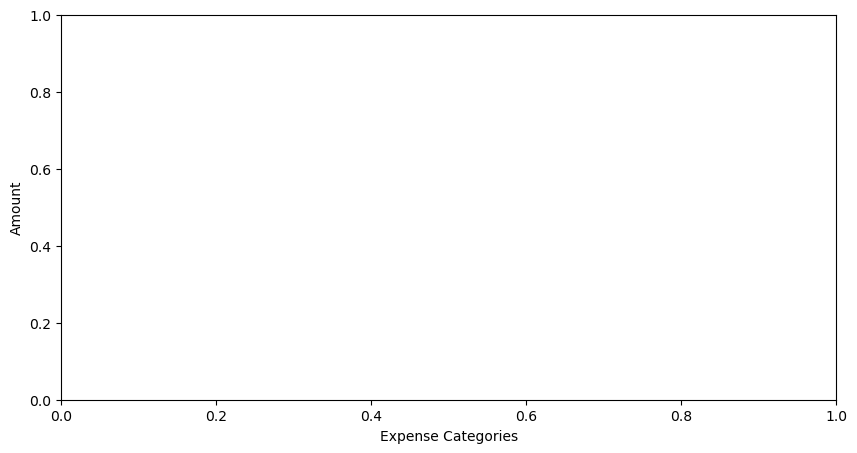

In [7]:
def plot_expenses(df):
    plt.figure(figsize=(10, 5))
    sns.barplot(x="Category", y="Spent", data=df, color="blue", label="Spent")
    sns.barplot(x="Category", y="Limit", data=df, color="black", alpha=0.5, label="Limit")
    
    plt.xlabel("Expense Categories")
    plt.ylabel("Amount")
    plt.title(f"{user_name}'s Expenses vs Budget Limits for {df['Month_Year'][0]}")
    plt.legend()
    plt.show()

plot_expenses(df)

In [ ]:
def plot_pie_chart(df):
    plt.figure(figsize=(8, 8))
    plt.pie(df["Spent"], labels=df["Category"], autopct='%1.1f%%', startangle=140, colors=['blue', 'red', 'green', 'orange', 'purple'])
    plt.title(f"{user_name}'s Expense Distribution for {df['Month_Year'][0]}")
    plt.show()

plot_pie_chart(df)

In [ ]:
# Function to Get Next Month's Date in MM/YY Format
def get_next_month_date(month_year):
    date_obj = datetime.datetime.strptime(month_year, "%m/%y")
    next_month = date_obj.replace(day=1) + datetime.timedelta(days=31)
    next_month = next_month.replace(day=1)  
    return next_month.strftime("%m/%y")

# Get Next Month
next_month_year = get_next_month_date(month_year)

# Predict Future Expenses
def predict_expenses(df):
    if len(df) < 2:  # Ensure at least 2 data points for prediction
        print("⚠️ Not enough data to predict next month's expenses.")
        return {}

    months = np.array(range(1, len(df) + 1)).reshape(-1, 1)  # Convert months to numerical values
    future_month = np.array([[len(df) + 1]])  # Next month prediction
    
    predictions = {}

    for category in df["Category"].unique():
        category_data = df[df["Category"] == category]
        
        if len(category_data) < 2:  # Ensure at least 2 data points for each category
            predictions[category] = category_data["Spent"].values[-1]  # Assume last value as prediction
            continue
        
        model = LinearRegression()
        spendings = category_data["Spent"].values.reshape(-1, 1)
        
        model.fit(months[:len(spendings)], spendings)
        predicted_spending = model.predict(future_month)[0][0]
        predictions[category] = round(predicted_spending, 2)
    
    return predictions

# Get Predicted Spending
predicted_spending = predict_expenses(df)

if predicted_spending:
    print(f"📅 {user_name}, your Predicted Spending for {next_month_year}: {predicted_spending}")

    # Convert to DataFrame
    pred_df = pd.DataFrame(list(predicted_spending.items()), columns=["Category", "Predicted Spending"])

    # 🔹 Bar Chart for Predicted Expenses
    def plot_predicted_bar_chart(pred_df, next_month_year):
        plt.figure(figsize=(4, 4))
        plt.bar(pred_df["Category"], pred_df["Predicted Spending"], color=["#A9A9A9", "#D3D3D3", "#B0C4DE", "#778899", "#696969"])
        plt.xlabel("Category", fontsize=10)
        plt.ylabel("Predicted Spending (₹)", fontsize=10)
        plt.title(f"{user_name}'s Predicted Expenses for {next_month_year}", fontsize=11)
        plt.xticks(rotation=45, fontsize=8)
        plt.yticks(fontsize=8)
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.show()

    # 🔹 Pie Chart for Predicted Expenses
    def plot_predicted_pie_chart(pred_df, next_month_year):
        plt.figure(figsize=(4, 4))
        colors = ["#D3D3D3", "#C0C0C0", "#B0C4DE", "#A9A9A9", "#778899"]
        plt.pie(pred_df["Predicted Spending"], labels=pred_df["Category"], autopct='%1.1f%%', startangle=140, colors=colors)
        plt.title(f"{user_name}'s Predicted Expense Distribution for {next_month_year}", fontsize=11)
        plt.show()

    # Show Charts
    plot_predicted_bar_chart(pred_df, next_month_year)
    plot_predicted_pie_chart(pred_df, next_month_year)

In [ ]:


# Function to Update Savings at the End of the Month & Show Graph
def update_savings_with_graph(total_money, expenses, savings, min_savings_limit):
    total_expenses = sum(expenses.values())  # Sum of all expenditures
    remaining_money = total_money - total_expenses  # Money left after expenses

    # Add remaining money to savings
    savings += remaining_money

    print("\n💰 End of Month Summary:")
    print(f"📉 Total Expenses: ₹{total_expenses}")
    print(f"💵 Remaining Money Added to Savings: ₹{remaining_money}")
    print(f"🏦 Updated Savings: ₹{savings}")

    # Warning if savings drop below minimum limit
    if savings < min_savings_limit:
        print("⚠️ Warning: Your savings have dropped below the minimum set limit!")

    # 🔹 Plot Bar Chart for Financial Summary
    categories = ["Total Money", "Total Expenses", "Updated Savings"]
    values = [total_money, total_expenses, savings]
    colors = ["#A9A9A9", "#D3D3D3", "#B0C4DE"]  # Neutral shades (Gray & Soft Blue)

    plt.figure(figsize=(4, 4))
    plt.bar(categories, values, color=colors)
    plt.xlabel("Financial Categories", fontsize=10)
    plt.ylabel("Amount (₹)", fontsize=10)
    plt.title("End-of-Month Financial Summary", fontsize=11)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

    return savings

In [ ]:
filename = "budget_data.csv"

try:
    existing_df = pd.read_csv(filename)
    df = pd.concat([existing_df, df], ignore_index=True)
except FileNotFoundError:
    pass  # No existing file

df.to_csv(filename, index=False)
print(f"Data for {month_year} saved successfully.")


In [ ]:
import pandas as pd
import os
import datetime

# Function to read last month's data
def get_last_month_data(filename="budget_data.csv"):
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        if not df.empty:
            last_month_data = df.iloc[-1]  # Get the last row (last month’s data)
            return last_month_data
    return None  # If file doesn't exist or is empty

# Function to get user input while showing last month's savings
def get_user_input(last_data):
    total_earnings = float(input("Enter your total earnings: "))

    # Show savings from last month and allow additional savings
    prev_savings = last_data["Updated Savings"] if last_data is not None else 0
    print(f"\nPrevious savings: {prev_savings}")
    additional_savings = float(input("Enter any additional savings for this month: "))
    total_savings = prev_savings + additional_savings

    min_savings_limit = float(input("Enter your minimum savings limit: "))

    # Expenses from last month (if available)
    categories = {}
    if last_data is not None:
        print("\nPrevious expenses & limits:")
        for column in last_data.index:
            if column not in ["Username", "Date", "Total Money", "Total Expenses", "Remaining Money", 
                              "Updated Savings", "Min Savings Limit", "Savings Goal", "Goal Cost", "Amount Needed for Goal"]:
                spent = last_data[column]
                limit = float(input(f"Set a new limit for {column} (Previous: {spent}): "))
                categories[column] = {"spent": spent, "limit": limit}

    # Allow setting a new savings goal
    goal_item = input("Enter a new savings goal (or press Enter to keep the last one): ").strip()
    if not goal_item and last_data is not None:
        goal_item = last_data["Savings Goal"]
        goal_cost = last_data["Goal Cost"]
    else:
        goal_cost = float(input(f"Enter the cost of {goal_item}: "))

    savings_goal = {"Item": goal_item, "Cost": goal_cost}

    return total_earnings, total_savings, min_savings_limit, categories, savings_goal

# Function to append new month's data to CSV
def append_monthly_budget_data(filename="budget_data.csv"):
    # Get Month and Year in MM/YY format
    month_year = input("Enter the month and year (MM/YY): ").strip()

    # Retrieve last month's data
    last_data = get_last_month_data(filename)

    # Get user input
    total_money, savings, min_savings_limit, expenses, savings_goal_item = get_user_input(last_data)

    # Calculate total expenses and remaining money
    total_expenses = sum(exp["spent"] for exp in expenses.values()) if expenses else 0
    remaining_money = total_money - total_expenses
    savings += remaining_money  # Add remaining money to savings

    # Prepare data dictionary
    new_data = {
        "Username": last_data["Username"] if last_data is not None else input("Enter your name: ").strip(),
        "Date": month_year,
        "Total Money": total_money,
        "Total Expenses": total_expenses,
        "Remaining Money": remaining_money,
        "Updated Savings": savings,
        "Min Savings Limit": min_savings_limit,
        "Savings Goal": savings_goal_item["Item"],
        "Goal Cost": savings_goal_item["Cost"],
        "Amount Needed for Goal": max(0, savings_goal_item["Cost"] - savings),
    }

    # Add expense categories
    for category, values in expenses.items():
        new_data[category] = values["spent"]

    # Convert new data to DataFrame
    new_df = pd.DataFrame([new_data])

    # Read existing CSV and append new data
    if os.path.exists(filename):
        try:
            existing_df = pd.read_csv(filename)
            updated_df = pd.concat([existing_df, new_df], ignore_index=True)  # Append new data
        except pd.errors.EmptyDataError:
            updated_df = new_df  # If file exists but is empty, use new data only
    else:
        updated_df = new_df  # If file doesn't exist, create a new one

    # Save updated data back to CSV
    updated_df.to_csv(filename, index=False)
    print(f"\n✅ Data for {month_year} added successfully to '{filename}'!")

# Run the function
append_monthly_budget_data()


In [ ]:
pd.read(filen)